## Exploring Streamflow data

This notebook allows the user to obtain different statistics from the daily streamflow data located in the data folder. The input csv should have the following structure

| Fecha         | Q      |
| :------       | :--    |
| dd/MM/YYYY    | 30.2   |

#### Import libraries

In [20]:
# Importing the libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import os

from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

##### Define user variables

In [21]:
# csv filename
station_name = '1190_sim'
# Percentage of missing data
max_pct_missing = 50
# Basin area
area_km2 = 690.20

In [22]:
# CSV folder
CSV_FOLDER = '..\..\..\Status_Outlook_Bulletin\stations\data'
CSV_FILE = os.path.join(CSV_FOLDER,station_name + '.csv')
print(CSV_FILE)

..\..\..\Status_Outlook_Bulletin\stations\data\1190_sim.csv


In [23]:
# Read file
DISCHARGE_DAILY = pd.read_csv(CSV_FILE,parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Identify the missing data
DISCHARGE_DAILY_date_missing = pd.date_range(start = DISCHARGE_DAILY.index[0].strftime('%Y-%m-%d'), end = DISCHARGE_DAILY.index[-1].strftime('%Y-%m-%d'),freq='D')
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
DISCHARGE_DAILY.index.name = 'Fecha' # Set index Fecha
DISCHARGE_DAILY.columns = ['Discharge']
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
# The water year for this region starts in April (4)
DISCHARGE_DAILY['water_year'] = DISCHARGE_DAILY.index.year.where(DISCHARGE_DAILY.index.month >= 4, DISCHARGE_DAILY.index.year - 1)
HTML(DISCHARGE_DAILY.head(6).to_html())

,Discharge,year,month,monthday,water_year
Fecha,,,,,
1970-05-14,25.450,1970,5,134,1970
1970-05-15,81.484,1970,5,135,1970
1970-05-16,16.759,1970,5,136,1970
1970-05-17,10.144,1970,5,137,1970
1970-05-18,6.878,1970,5,138,1970
1970-05-19,5.544,1970,5,139,1970


##### Plot hydrograph

In [24]:
fig = go.Figure()

# Original discharge
fig.add_trace(go.Scatter(
    x=DISCHARGE_DAILY.index,    
    y=DISCHARGE_DAILY['Discharge'], 
    mode='lines+markers',               
    name='Streamflow (m3/s) - Original'
))

fig.update_layout(
    title=f'Hydrograph',
    xaxis_title='Date',
    yaxis_title='Discharge (m³/s)'
)

fig.show()

##### Duration Curve

In [25]:
DATA_DAILY = DISCHARGE_DAILY.dropna(subset=['Discharge'])
sorted_stage= DATA_DAILY['Discharge'].sort_values(ascending=False)
freq_stage = np.arange(1., len(sorted_stage) + 1) / len(sorted_stage)

df_freq = sorted_stage.to_frame(name='stage')
df_freq['frequency'] = freq_stage

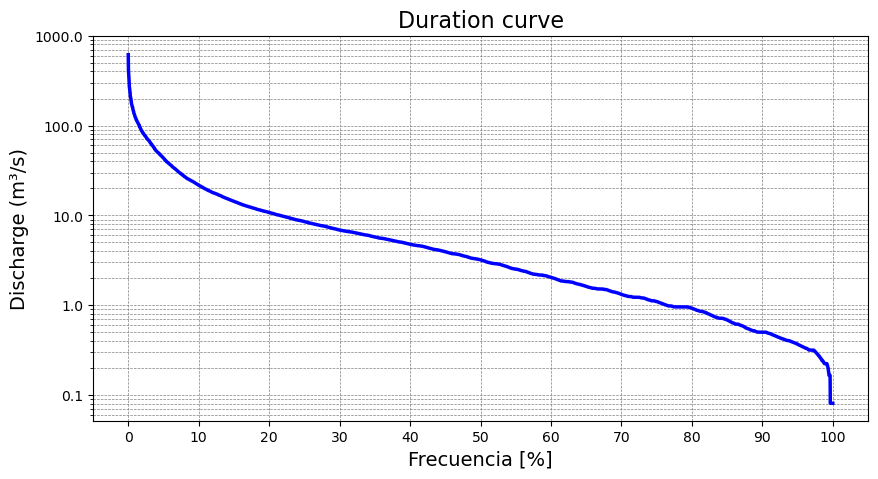

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# Create the matplotlib plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq_stage * 100, sorted_stage, color='blue', linewidth=2.5)

ax.set_title('Duration curve', fontsize=16)
ax.set_xlabel('Frecuencia [%]', fontsize=14)
ax.set_ylabel('Discharge (m³/s)', fontsize=14)

# Set y-axis to log scale
ax.set_yscale('log')

# Set x and y-axis ticks and format
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks([0.1, 1, 10, 100, 1000])
ax.get_yaxis().set_major_formatter(ScalarFormatter())

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')


##### Convert to monthly

In [27]:
# from daily to monthly
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M',closed="right").apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# from monthly to 3 months
DISCHARGE_THREE_MONTHS = DISCHARGE_MONTHLY.rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# Create columns
DISCHARGE_MONTHLY['year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['month'] = DISCHARGE_MONTHLY.index.month
DISCHARGE_MONTHLY['water_year'] = DISCHARGE_MONTHLY.index.year.where(DISCHARGE_MONTHLY.index.month >= 4, DISCHARGE_MONTHLY.index.year - 1)

# Change the day in the datetime column
DISCHARGE_MONTHLY.index = DISCHARGE_MONTHLY.index.map(lambda t: t.replace(day=1))
## print the first results
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=True))
# DISCHARGE_MONTHLY.to_clipboard() # Uncomment if you want to visualize all the time serie

,Discharge,year,month,monthday,water_year
Fecha,,,,,
2025-01-01,0.409601,2025,1,16.0,2024
2025-02-01,0.387018,2025,2,45.5,2024
2025-03-01,1.192894,2025,3,75.0,2024
2025-04-01,1.038680,2025,4,105.5,2025
2025-05-01,4.300796,2025,5,136.0,2025
2025-06-01,10.100411,2025,6,166.5,2025


#### Convert to daily volumen in m3 and hm3

In [28]:
# Convert daily discharge (m³/s) to daily volume (hm³)
seconds_in_a_day = 86400
DISCHARGE_DAILY['Daily_Volume_m3'] = DISCHARGE_DAILY['Discharge'] * seconds_in_a_day
DISCHARGE_DAILY['Daily_Volume_hm3'] = DISCHARGE_DAILY['Daily_Volume_m3'] / 1e6
HTML(DISCHARGE_DAILY.head(6).to_html(index=True))

,Discharge,year,month,monthday,water_year,Daily_Volume_m3,Daily_Volume_hm3
Fecha,,,,,,,
1970-05-14,25.450,1970,5,134,1970,2198880.0,2.198880
1970-05-15,81.484,1970,5,135,1970,7040217.6,7.040218
1970-05-16,16.759,1970,5,136,1970,1447977.6,1.447978
1970-05-17,10.144,1970,5,137,1970,876441.6,0.876442
1970-05-18,6.878,1970,5,138,1970,594259.2,0.594259
1970-05-19,5.544,1970,5,139,1970,479001.6,0.479002


In [29]:
# Calculate the day of the water year (1 to 365/366)
def get_water_year_day(date):
    start_of_water_year = pd.Timestamp(year=date.year, month=4, day=1)
    if date.month < 4:
        start_of_water_year = pd.Timestamp(year=date.year - 1, month=4, day=1)
    
    return (date - start_of_water_year).days + 1

DISCHARGE_DAILY['day_of_water_year'] = DISCHARGE_DAILY.index.map(get_water_year_day)
HTML(DISCHARGE_DAILY.head(6).to_html(index=True))

,Discharge,year,month,monthday,water_year,Daily_Volume_m3,Daily_Volume_hm3,day_of_water_year
Fecha,,,,,,,,
1970-05-14,25.450,1970,5,134,1970,2198880.0,2.198880,44
1970-05-15,81.484,1970,5,135,1970,7040217.6,7.040218,45
1970-05-16,16.759,1970,5,136,1970,1447977.6,1.447978,46
1970-05-17,10.144,1970,5,137,1970,876441.6,0.876442,47
1970-05-18,6.878,1970,5,138,1970,594259.2,0.594259,48
1970-05-19,5.544,1970,5,139,1970,479001.6,0.479002,49


##### How much it would take to fill the reservoir?

In [30]:
# Group by water_year and calculate the cumulative volume
df_cumulative = DISCHARGE_DAILY.groupby('water_year')['Daily_Volume_hm3'].cumsum().reset_index()
df_cumulative['day_of_water_year'] = DISCHARGE_DAILY['day_of_water_year'].values
df_cumulative['water_year'] = DISCHARGE_DAILY['water_year'].values
df_cumulative['Discharge'] = DISCHARGE_DAILY['Discharge'].values
# Filter the DataFrame for the last 10 water years (2014 to 2024)
df_filtered = df_cumulative[(df_cumulative['water_year'] >= 1970) & (df_cumulative['water_year'] <= 2024)]
HTML(df_filtered.head(6).to_html(index=False))

Fecha,Daily_Volume_hm3,day_of_water_year,water_year,Discharge
1970-05-14,2.198880,44,1970,25.450
1970-05-15,9.239098,45,1970,81.484
1970-05-16,10.687075,46,1970,16.759
1970-05-17,11.563517,47,1970,10.144
1970-05-18,12.157776,48,1970,6.878
1970-05-19,12.636778,49,1970,5.544


In [31]:
# Ensure df_cumulative has a datetime index (if not, set it)
if not isinstance(df_cumulative.index, pd.DatetimeIndex):
    df_cumulative.index = pd.to_datetime(df_cumulative.index)

# Resample to monthly total volume
monthly_volume = DISCHARGE_DAILY['Daily_Volume_hm3'].resample('M').sum()

# Calculate rolling 12-month sum
rolling_12m = monthly_volume.rolling(window=12).sum()

# Find the start of the 12-month period with the lowest cumulative volume
min_idx = rolling_12m.idxmin()
min_period = monthly_volume.loc[min_idx - pd.DateOffset(months=11):min_idx]

print("12 consecutive months with lowest cumulative volume:")
print(min_period)
print(f"Total volume: {min_period.sum():.2f} hm³")

12 consecutive months with lowest cumulative volume:
Fecha
1988-12-31    1.905206
1989-01-31    0.739238
1989-02-28    0.668477
1989-03-31    0.801446
1989-04-30    1.515802
1989-05-31    1.805242
1989-06-30    1.671840
1989-07-31    2.114726
1989-08-31    2.862691
1989-09-30    2.478125
1989-10-31    1.449187
1989-11-30    2.343514
Freq: M, Name: Daily_Volume_hm3, dtype: float64
Total volume: 20.36 hm³


In [32]:
# Create the plot with custom legend labels for water years
df_filtered = df_filtered.copy()
df_filtered['water_year_label'] = df_filtered['water_year'].astype(str) + '/' + (df_filtered['water_year']+1).astype(str)

fig = px.line(
    df_filtered, 
    x='day_of_water_year', 
    y='Daily_Volume_hm3', 
    color='water_year_label',
    title='Cumulative Volume by Water Year',
    labels={'day_of_water_year': 'Day of Water Year', 'Daily_Volume_hm3': 'Cumulative Volume (hm³)', 'water_year_label': 'Water Year'}
)

# Add a horizontal line at 118 hm3 - Casupá Reservoir Capacity
fig.add_hline(y=118, line_dash="dash", line_color="red", annotation_text="118 hm³", annotation_position="top left")

# Customize the plot layout
fig.update_layout(
    xaxis_title='Day of Water Year',
    yaxis_title='Volume (hm³)'
)

# Show the plot
fig.show()

In [33]:
import numpy as np
import pandas as pd

# Days of water year to check
check_days = [50, 100, 150, 200, 250, 300, 350]
threshold = 118  # hm³

# For each day, calculate the probability to surpass the threshold
results = {}
for day in check_days:
    vols = df_filtered[df_filtered['day_of_water_year'] == day]['Daily_Volume_hm3']
    prob = np.mean(vols >= threshold)
    results[day] = prob
    print(f"Día {day}: Probabilidad llenar Casupá ({threshold} hm³) = {prob:.1%}")

# Display as a DataFrame
prob_df = pd.DataFrame({'Day_of_Water_Year': check_days, 'Probability_to_Surpass_118_hm3': [results[d] for d in check_days]})
prob_df

Día 50: Probabilidad llenar Casupá (118 hm³) = 10.9%
Día 100: Probabilidad llenar Casupá (118 hm³) = 38.2%
Día 150: Probabilidad llenar Casupá (118 hm³) = 70.9%
Día 200: Probabilidad llenar Casupá (118 hm³) = 85.5%
Día 250: Probabilidad llenar Casupá (118 hm³) = 87.3%
Día 300: Probabilidad llenar Casupá (118 hm³) = 90.9%
Día 350: Probabilidad llenar Casupá (118 hm³) = 94.5%


,Day_of_Water_Year,Probability_to_Surpass_118_hm3
0,50,0.109091
1,100,0.381818
2,150,0.709091
3,200,0.854545
4,250,0.872727
5,300,0.909091
6,350,0.945455


In [34]:
import plotly.express as px
import pandas as pd

# Days of water year to check
check_days = [50, 100, 150, 200, 250, 300, 350]

# Gather cumulative volumes for each day
boxplot_data = []
for day in check_days:
    vols = df_filtered[df_filtered['day_of_water_year'] == day][['Daily_Volume_hm3', 'water_year_label']]
    vols = vols.copy()
    vols['Day_of_Water_Year'] = day
    boxplot_data.append(vols)

boxplot_df = pd.concat(boxplot_data)

# Create boxplot
fig = px.box(
    boxplot_df,
    x='Day_of_Water_Year',
    y='Daily_Volume_hm3',
    points='all',
    title='Cumulative Volume by Water Year - Selected Days',
    labels={'Daily_Volume_hm3': 'Cumulative Volume (hm³)', 'Day_of_Water_Year': 'Day of Water Year'}
)

# Add threshold line
fig.add_hline(y=118, line_dash="dash", line_color="red", annotation_text="118 hm³", annotation_position="top left")
fig.update_layout(xaxis=dict(tickmode='array', tickvals=check_days))
fig.show()

In [35]:
import pandas as pd

# Days of water year to check
check_days = [50, 100, 150, 200, 250, 300, 350]
threshold = 118  # hm³

results = []
for day in check_days:
    vols = df_filtered[df_filtered['day_of_water_year'] == day][['Daily_Volume_hm3', 'water_year']]
    total_years = vols['water_year'].nunique()
    exceeded_years = vols[vols['Daily_Volume_hm3'] >= threshold]['water_year'].nunique()
    probability = exceeded_years / total_years if total_years > 0 else None
    results.append({'Day_of_Water_Year': day, 'Total_Water_Years': total_years, 'Exceeded_Years': exceeded_years, 'Probability': probability})
    print(f"Day {day}: {exceeded_years}/{total_years} water years exceeded {threshold} hm³ (Probability: {probability:.2%} if not None else 'N/A')")

prob_table = pd.DataFrame(results)
prob_table

Day 50: 6/55 water years exceeded 118 hm³ (Probability: 10.91% if not None else 'N/A')
Day 100: 21/55 water years exceeded 118 hm³ (Probability: 38.18% if not None else 'N/A')
Day 150: 39/55 water years exceeded 118 hm³ (Probability: 70.91% if not None else 'N/A')
Day 200: 47/55 water years exceeded 118 hm³ (Probability: 85.45% if not None else 'N/A')
Day 250: 48/55 water years exceeded 118 hm³ (Probability: 87.27% if not None else 'N/A')
Day 300: 50/55 water years exceeded 118 hm³ (Probability: 90.91% if not None else 'N/A')
Day 350: 52/55 water years exceeded 118 hm³ (Probability: 94.55% if not None else 'N/A')


,Day_of_Water_Year,Total_Water_Years,Exceeded_Years,Probability
0,50,55,6,0.109091
1,100,55,21,0.381818
2,150,55,39,0.709091
3,200,55,47,0.854545
4,250,55,48,0.872727
5,300,55,50,0.909091
6,350,55,52,0.945455


In [36]:
import plotly.graph_objects as go

# Sum total volume for each water year
annual_volumes = df_filtered.groupby('water_year_label')['Daily_Volume_hm3'].max().reset_index()

# Calculate mean (media) of the series
mean_volume = 272 # Provided by user

# Create bar plot
fig = go.Figure()
fig.add_trace(go.Bar(
    x=annual_volumes['water_year_label'].astype(str),
    y=annual_volumes['Daily_Volume_hm3'],
    name='Total Volume per Water Year',
    marker_color='royalblue'
))

# Add threshold line at 118 hm³
fig.add_hline(y=118, line_dash="dash", line_color="red", annotation_text="118 hm³", annotation_position="top left")

# Add a bar for the mean (media) of the series at the end
fig.add_trace(go.Bar(
    x=['Media'],
    y=[mean_volume],
    name='Media de la serie',
    marker_color='orange'
))

fig.update_layout(
    title='Volumen total (hm³) por año hidrológico',
    xaxis_title='Año hidrológico',
    yaxis_title='Volumen total (hm³)',
    showlegend=False
)

fig.show()

In [ ]:
import plotly.graph_objects as go

# Prepare data: total volume per water year and Media bar
annual_volumes = df_filtered.groupby('water_year_label')['Daily_Volume_hm3'].max().reset_index()
media_row = {'water_year_label': 'Media', 'Daily_Volume_hm3': 272}
annual_volumes_with_media = annual_volumes.append(media_row, ignore_index=True)

# Sort by volume (including Media)
annual_volumes_sorted = annual_volumes_with_media.sort_values('Daily_Volume_hm3')

# Create bar plot with sorted bars
fig = go.Figure()
fig.add_trace(go.Bar(
    x=annual_volumes_sorted['water_year_label'],
    y=annual_volumes_sorted['Daily_Volume_hm3'],
    marker_color=['orange' if label == 'Media' else 'royalblue' for label in annual_volumes_sorted['water_year_label']],
    # text=annual_volumes_sorted['Daily_Volume_hm3'].round(1),
    # textposition='outside',
    name='Volumen total por año hidrológico (ordenado)')
)

# Add threshold line at 118 hm³
fig.add_hline(y=118, line_dash="dash", line_color="red", annotation_text="118 hm³", annotation_position="top left")

fig.update_layout(
    title='Volumen total (hm³) por año hidrológico',
    xaxis_title='Año hidrológico',
    yaxis_title='Volumen total (hm³)',
    showlegend=False
)

fig.show()

In [ ]:
df_filtered.to_clipboard()


##### Climatology 

In [ ]:
DISCHARGE_SELECTION = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY['year'] >= 1980) & (DISCHARGE_MONTHLY['year'] <= 2010)]
DISCHARGE_AVERAGE = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).mean()
DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.reindex(columns=['Discharge'])
HTML(DISCHARGE_AVERAGE.transpose().round(decimals=2).to_html())

In [ ]:
VOLUME_SELECTION = monthly_volume[(monthly_volume.index.year >= 1980) & (monthly_volume.index.year <= 2010)]
VOLUME_AVERAGE = pd.DataFrame(VOLUME_SELECTION.groupby(VOLUME_SELECTION.index.month).mean())
# VOLUME_AVERAGE = VOLUME_AVERAGE.reindex(columns=['Daily_Volume_hm3'])
HTML(VOLUME_AVERAGE.transpose().round(decimals=1).to_html())

In [ ]:
print(f"the annual volume is: {VOLUME_AVERAGE['Daily_Volume_hm3'].sum().round(2)}")

In [ ]:
import plotly.express as px

# Agregar columna con abreviaturas de mes en español
meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN',
         'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.copy()
DISCHARGE_AVERAGE['Mes'] = [meses[m-1] for m in DISCHARGE_AVERAGE.index]

# Crear gráfico de barras con etiquetas de valores
fig = px.bar(
    DISCHARGE_AVERAGE,
    x='Mes',
    y='Discharge',
    labels={'Discharge': 'Discharge (m³/s)', 'Mes': 'Month'},
    title='Monthly Discharge',
    text='Discharge'  # Add this line to show values
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')  # Format and position labels
fig.update_layout(
    xaxis_tickfont=dict(size=14),
    yaxis_tickfont=dict(size=14),
    title_font=dict(size=20)
)

fig.show()

In [ ]:
import plotly.express as px

# Agregar columna con abreviaturas de mes en español
meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN',
         'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

VOLUME_AVERAGE = VOLUME_AVERAGE.copy()
VOLUME_AVERAGE['Mes'] = [meses[m-1] for m in VOLUME_AVERAGE.index]

# Crear gráfico de barras con etiquetas de valores
fig = px.bar(
    VOLUME_AVERAGE,
    x='Mes',
    y='Daily_Volume_hm3',
    labels={'Daily_Volume_hm3': 'Volume (hm³)', 'Mes': 'Month'},
    title='Monthly Volume',
    text='Daily_Volume_hm3'  # Mostrar valores en las barras
)

fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')  # Formato y posición de las etiquetas
fig.update_layout(
    xaxis_tickfont=dict(size=14),
    yaxis_tickfont=dict(size=14),
    title_font=dict(size=20)
)

fig.show()

In [ ]:
VOLUME_AVERAGE['Daily_Volume_hm3'].sum()

##### Calculate annual statistics

In [ ]:
q = (DISCHARGE_SELECTION['Discharge'].mean() * 1000) / area_km2
v = (DISCHARGE_SELECTION['Discharge'].mean() * 31557600) / 1000000 # Convert from m3/s to hm3/year

print(f"El caudal promedio anual es (1980-2010): {DISCHARGE_SELECTION['Discharge'].mean():.1f} m³/s")
print(f"El caudal especifico es (1980-2010): {q:.1f} l/s/km²")
print(f"El volumen anual promedio es (1980-2010):{v:.1f} hm³")
print(f"El q80 anual (Caudal frecuencia 80% del tiempo) es (1980-2010): {np.percentile(DATA_DAILY['Discharge'], 20):.1f} m³/s")
print(f"El V80 anual (Volumen frecuencia 80% del tiempo) es (1980-2010): {(np.percentile(DATA_DAILY['Discharge'], 20)*31557600)/1e6:.1f} hm³")

##### Monthly period

In [ ]:
# Define the monthly periods
monthly_periods = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'
}

results = {}

for month_num, month_label in monthly_periods.items():
    # Filter the monthly data for the current month
    monthly_data = DISCHARGE_SELECTION[DISCHARGE_SELECTION['month'] == month_num]
    
    # Calculate the mean discharge
    mean_discharge = monthly_data['Discharge'].mean()
    
    # Calculate q and Q80
    q = (mean_discharge * 1000) / area_km2
    Q80 = np.nanpercentile(monthly_data['Discharge'], 20)
    Q20 = np.nanpercentile(monthly_data['Discharge'], 80)
    Q90 = np.nanpercentile(monthly_data['Discharge'], 10)
    Q10 = np.nanpercentile(monthly_data['Discharge'], 90)
    Q60 = np.nanpercentile(monthly_data['Discharge'], 40)
    Q40 = np.nanpercentile(monthly_data['Discharge'], 60)

    Qmax = np.nanmax(monthly_data['Discharge'])
    Qmin = np.nanmin(monthly_data['Discharge'])

    # Specific discharge
    q80 = (Q80*1000)/area_km2
    q20 = (Q20*1000)/area_km2
    qmax = (Qmax*1000)/area_km2
    qmin = (Qmin*1000)/area_km2
    
    # Calculate the average monthly volume
    seconds_in_a_year = 31557600
    seconds_in_a_month_avg = seconds_in_a_year / 12
    v_month = (mean_discharge * seconds_in_a_month_avg) / 1e6

    results[month_label] = {'mean_discharge (m³/s)': mean_discharge, 
                            'q (l/s/km²)': q, 
                            'Vol (hm³)': v_month, 
                            'Q80 (m³/s)': Q80, 
                            'q80 (l/s/km²)':q80,
                            'Q20 (m³/s)':Q20,
                            'q20 (l/s/km²)':q20,
                            'qmax (l/s/km²)':qmax,
                            'qmin (l/s/km²)':qmin}

# Print the results in a clear format
for month, values in results.items():
    print(f"--- Resultados para {month} ---")
    print(f"El caudal promedio (1980-2010): {values['mean_discharge (m³/s)']:.2f} m³/s")
    print(f"El caudal especifico (1980-2010): {values['q (l/s/km²)']:.2f} l/s/km²")
    print(f"El volumen mensual promedio (1980-2010): {values['Vol (hm³)']:.2f} hm³")
    print(f"El Q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): {values['Q80 (m³/s)']:.2f} m³/s ({(values['Q80 (m³/s)']*1000)/area_km2:.1f} l/s/km²)")
    print()

In [ ]:
# Create the DataFrame from the results dictionary
df_results = pd.DataFrame(results).round(decimals=1)
# Define the new desired order of months
new_order = ['Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic', 'Ene', 'Feb', 'Mar']
# Reorder the DataFrame columns
df_results = df_results[new_order]
df_results

#### Four-month period analysis

In [ ]:
# Define the periods
periods = {
    'q1': ([4, 5, 6, 7],"ABR-JUL"),
    'q2': ([8, 9, 10, 11],"AGO-NOV"),
    'q3': ([12, 1, 2, 3],"DIC-MAR")
}

results = {}

for period_name, (months, period_label) in periods.items():
    # Filter the monthly data for the current period
    DISCHARGE_q = DISCHARGE_SELECTION[DISCHARGE_SELECTION.index.month.isin(months)]

    # Calculate the mean discharge
    mean_discharge = DISCHARGE_q['Discharge'].mean()

    # Calculate q and q80
    q = (mean_discharge * 1000) / area_km2
    Q80 = np.nanpercentile(DISCHARGE_q['Discharge'], 20)
    Q60 = np.nanpercentile(DISCHARGE_q['Discharge'], 40)
    Q90 = np.nanpercentile(DISCHARGE_q['Discharge'], 10)

    # Calculate the average four-month volume
    seconds_in_a_year = 31557600
    seconds_in_four_months = seconds_in_a_year * (4/12)
    v_four_month = (mean_discharge * seconds_in_four_months) / 1e6

    # Calculate q80 in hm3
    v80 = (Q80 * seconds_in_four_months) / 1e6

    results[period_name] = {'mean_discharge (m³/s)': mean_discharge, 
                            'q (l/s/km²)': q, 
                            'Vol (hm³)': v_four_month, 
                            'period_label': period_label, 
                            'Q80 (m³/s)': Q80,
                            'v80 (hm³)': v80,}

# Print the results in the user's requested format
for period_name, values in results.items():
    print(f"--- Resultados para {values['period_label']} ---")
    print(f"El caudal promedio (1980-2010): {values['mean_discharge (m³/s)']:.1f} m³/s")
    print(f"El caudal especifico (1980-2010): {values['q (l/s/km²)']:.1f} l/s/km²")
    print(f"El volumen cuatrimestral promedio (1980-2010): {values['Vol (hm³)']:.1f} hm³")
    print(f"El Q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): {values['Q80 (m³/s)']:.2f} m³/s")
    print()

In [ ]:
# Assuming 'results' is your dictionary variable
for period_name in results:
    results[period_name].pop('period_label', None)

# Create the DataFrame from the results dictionary
df_results_fourmonth = pd.DataFrame(results)

# Now apply rounding to the numerical values
df_results_fourmonth = df_results_fourmonth.round(decimals=1)

# Rename the columns for better readability
df_results_fourmonth.rename(columns={'q1': 'ABR-JUL', 'q2': 'AGO-NOV', 'q3': 'DIC-MAR'}, inplace=True)

# Display the final, corrected DataFrame
df_results_fourmonth

In [ ]:
seconds_in_four_months